# **03 - Data Cleaning**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/pieterkdevilliers/Desktop/Development/Code Institute/pp5-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pieterkdevilliers/Desktop/Development/Code Institute/pp5-heritage-housing'

# Load Collected Data

Section 1 content

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,0.0,548.0,RFn,...,65.0,196.0,61.0,5.0,7.0,856.0,0.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,NaN,460.0,RFn,...,80.0,0.0,0.0,8.0,6.0,1262.0,NaN,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,0.0,608.0,RFn,...,68.0,162.0,42.0,5.0,7.0,920.0,NaN,2001,2002,223500.0


---

# Data Exploration

In Data Cleaning you are interested to check the distribution and shape of a variable with missing data.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

/var/folders/vg/xr2t0ncx7c98wfntvs622gs80000gn/T/ipykernel_52160/3398083222.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Correlation and PPS Analysis

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


Calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/var/folders/vg/xr2t0ncx7c98wfntvs622gs80000gn/T/ipykernel_52160/3909134160.py:37: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_spearman = df.corr(method="spearman")
/var/folders/vg/xr2t0ncx7c98wfntvs622gs80000gn/T/ipykernel_52160/3909134160.py:38: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_pearson = df.corr(method="pearson")
/opt/homebrew/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Display at Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



/var/folders/vg/xr2t0ncx7c98wfntvs622gs80000gn/T/ipykernel_52160/3909134160.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


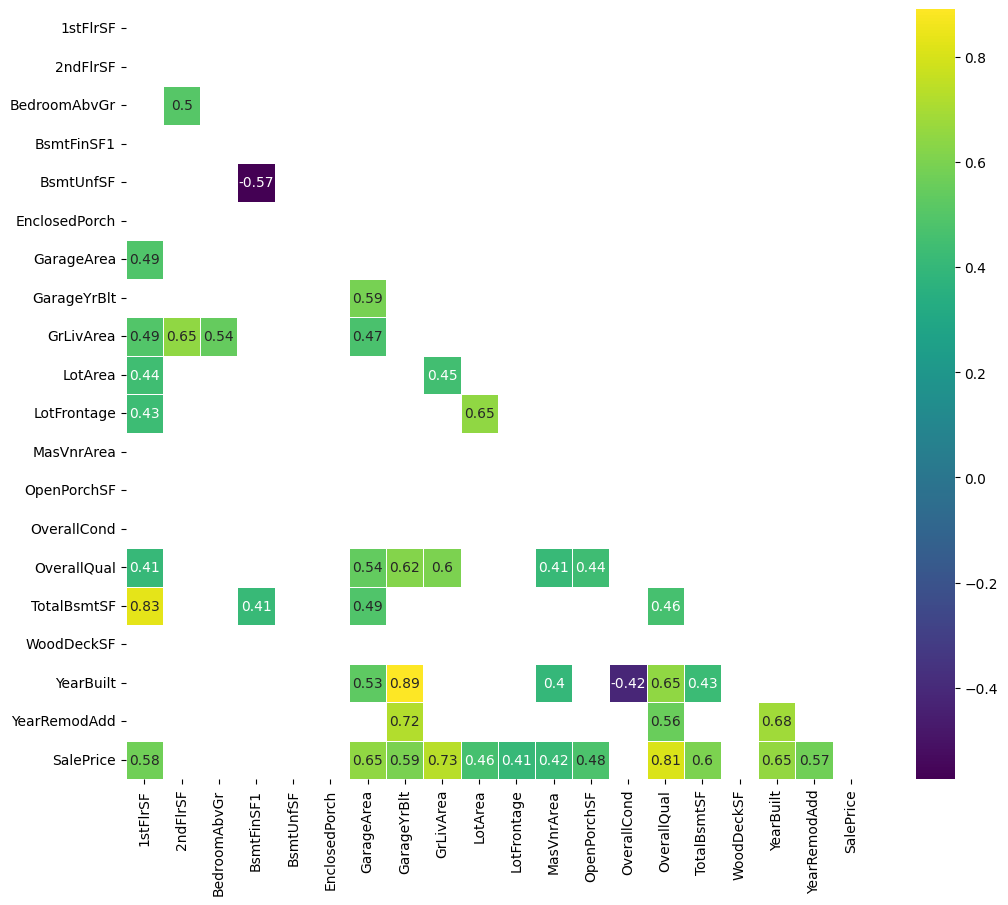



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



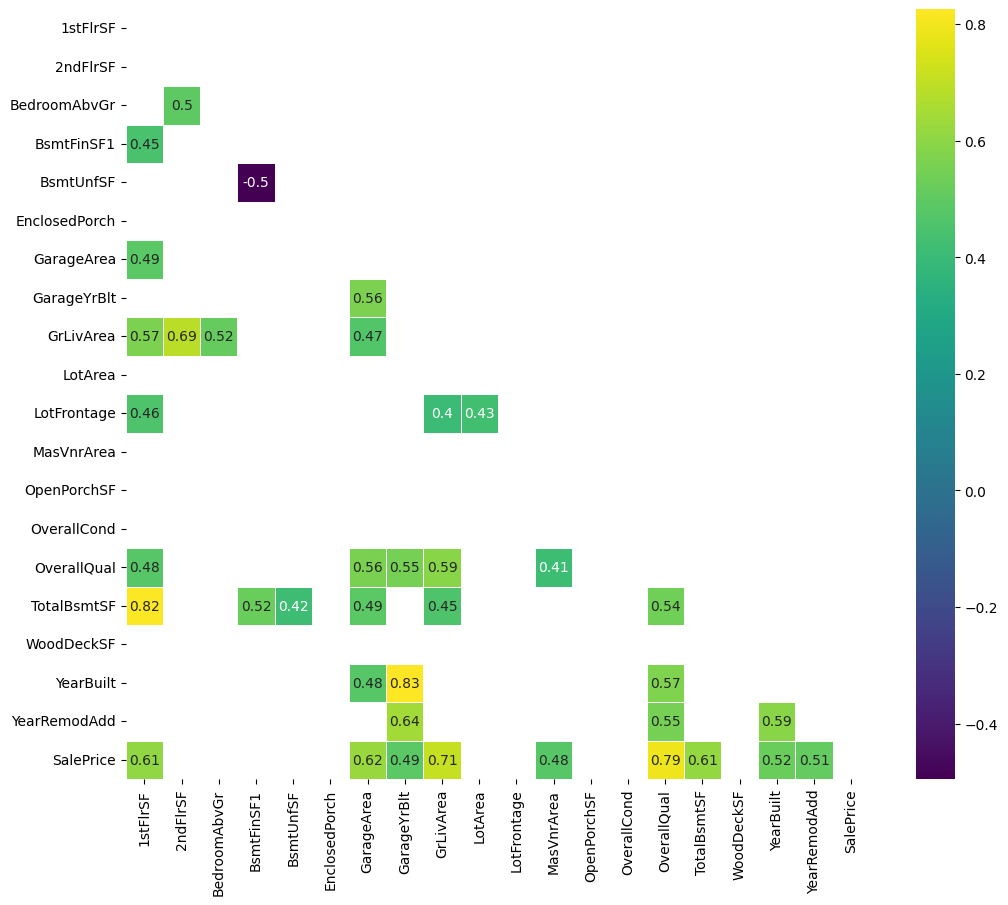



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



/var/folders/vg/xr2t0ncx7c98wfntvs622gs80000gn/T/ipykernel_52160/3909134160.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


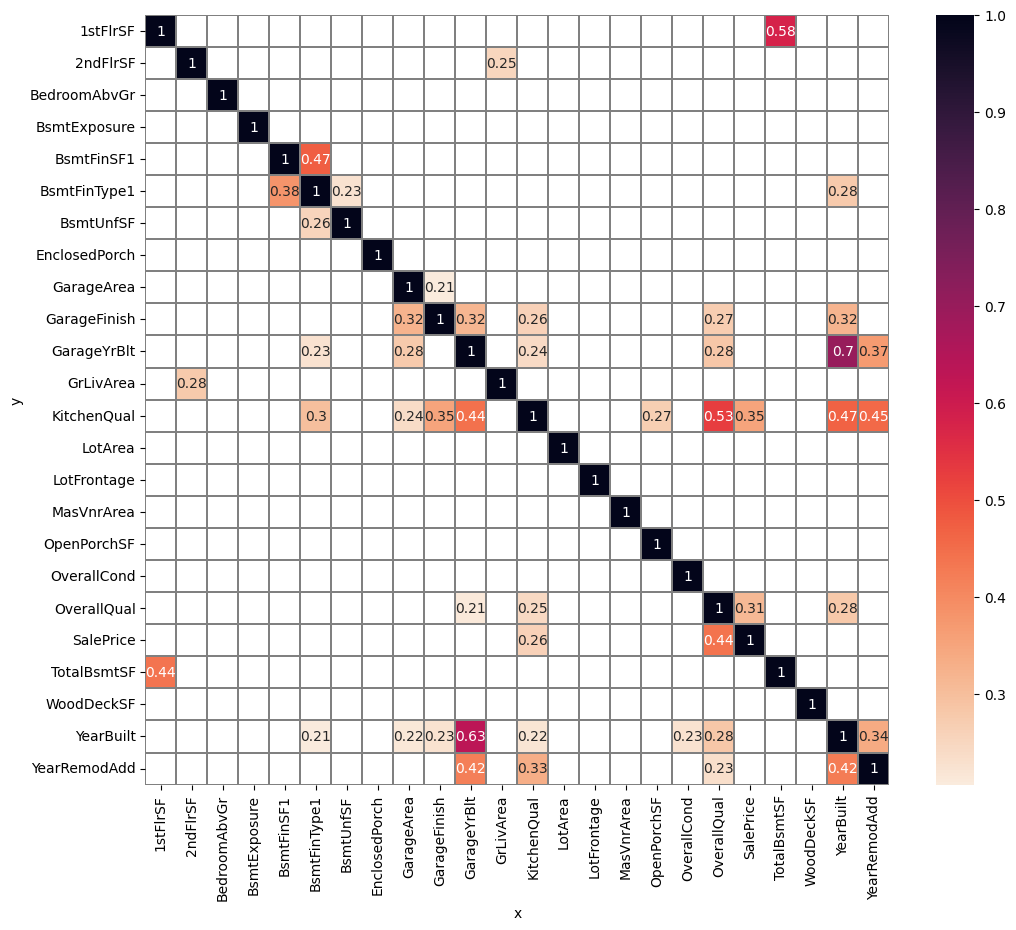

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

---

# Data Cleaning

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [13]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


## Dealing with missing data

1 - Drop 'EnlcosedPorch' and 'WoodDeckSF' as they have around 90% missing data

2 - Impute for 'LotFrontage', 'GarageFinish', 'BsmtFinType1', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'

### Split Train and Test Set

In [14]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [15]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


NOTE

In [16]:
variables_method = ['EnclosedPorch', 'WoodDeckSF' ]

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


In [17]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

In [18]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

## Replace missing data with median

In [19]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 7 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


Replace missing data on remaining numerical features

In [20]:
from feature_engine.imputation import MeanMedianImputer
imputer = MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'])
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

In [21]:
df_missing_data = EvaluateMissingData(df_method)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 2 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object


Apply this to TestSet

In [22]:
from feature_engine.imputation import MeanMedianImputer
test_imputer = MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'])
test_imputer.fit(TestSet)
test_df_method = test_imputer.transform(TestSet)

In [23]:
test_df_missing_data = EvaluateMissingData(test_df_method)
print(f"* There are {test_df_missing_data.shape[0]} variables with missing data \n")
test_df_missing_data

* There are 2 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,31,10.62,object
BsmtFinType1,25,8.56,object


As these remaining are object data types, they will need additional processing

In [24]:
dic = {
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
}

df_method[['BsmtFinType1', 'GarageFinish']] = df_method[['BsmtFinType1', 'GarageFinish']].replace(dic)

df_method[['BsmtFinType1', 'GarageFinish']].head(5)


,BsmtFinType1,GarageFinish
618,NaN,1.0
870,1.0,NaN
92,5.0,1.0
817,6.0,2.0
302,1.0,2.0


Replace missing values with Impute Median

In [25]:
from feature_engine.imputation import MeanMedianImputer
imputer = MeanMedianImputer(imputation_method='median', variables=['BsmtFinType1', 'GarageFinish'])
imputer.fit(df_method)
df_method = imputer.transform(df_method)
df_method.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828.0,0.0,3.0,Av,48.0,4.0,1774.0,774.0,1.0,2007.0,...,11694.0,90.0,452.0,108.0,5.0,9.0,1822.0,2007,2007,314813.0
870,894.0,0.0,2.0,No,0.0,1.0,894.0,308.0,2.0,1962.0,...,6600.0,60.0,0.0,0.0,5.0,5.0,894.0,1962,1962,109500.0
92,964.0,0.0,2.0,No,713.0,5.0,163.0,432.0,1.0,1921.0,...,13360.0,80.0,0.0,0.0,7.0,5.0,876.0,1921,2006,163500.0
817,1689.0,0.0,3.0,No,1218.0,6.0,350.0,857.0,2.0,2002.0,...,13265.0,69.0,148.0,59.0,5.0,8.0,1568.0,2002,2002,271000.0
302,1541.0,0.0,3.0,No,0.0,1.0,1541.0,843.0,2.0,2001.0,...,13704.0,118.0,150.0,81.0,5.0,7.0,1541.0,2001,2002,205000.0
1454,1221.0,0.0,2.0,No,410.0,6.0,811.0,400.0,2.0,2004.0,...,7500.0,62.0,0.0,113.0,5.0,7.0,1221.0,2004,2005,185000.0
40,1324.0,0.0,3.0,No,643.0,3.0,445.0,440.0,2.0,1965.0,...,8658.0,84.0,101.0,138.0,5.0,6.0,1088.0,1965,1965,160000.0
959,696.0,720.0,3.0,No,604.0,5.0,92.0,484.0,1.0,1999.0,...,2572.0,24.0,0.0,44.0,5.0,7.0,696.0,1999,1999,155000.0
75,526.0,462.0,2.0,Gd,462.0,6.0,0.0,297.0,1.0,1973.0,...,1596.0,21.0,0.0,101.0,5.0,4.0,462.0,1973,1973,91000.0
1389,869.0,349.0,3.0,No,375.0,5.0,360.0,440.0,1.0,2003.0,...,6000.0,60.0,0.0,0.0,6.0,6.0,735.0,1941,1950,131000.0


In [26]:
df_missing_data = EvaluateMissingData(df_method)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


Do the same for the TestSet

In [27]:
dic = {
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
}

test_df_method[['BsmtFinType1', 'GarageFinish']] = test_df_method[['BsmtFinType1', 'GarageFinish']].replace(dic)

test_df_method[['BsmtFinType1', 'GarageFinish']].head(5)


,BsmtFinType1,GarageFinish
529,3.0,NaN
491,4.0,1.0
459,2.0,1.0
279,4.0,3.0
655,1.0,1.0


In [28]:
from feature_engine.imputation import MeanMedianImputer
test_imputer = MeanMedianImputer(imputation_method='median', variables=['BsmtFinType1', 'GarageFinish'])
test_imputer.fit(test_df_method)
test_df_method = test_imputer.transform(test_df_method)
test_df_method.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
529,2515.0,0.0,4.0,No,1219.0,3.0,816.0,484.0,2.0,1975.0,...,32668.0,70.0,0.0,0.0,3.0,6.0,2035.0,1957,1975,200624.0
491,958.0,620.0,3.0,No,403.0,4.0,238.0,240.0,1.0,1941.0,...,9490.0,79.0,0.0,0.0,7.0,6.0,806.0,1941,1950,133000.0
459,979.0,224.0,3.0,No,185.0,2.0,524.0,352.0,1.0,1950.0,...,7015.0,70.0,161.0,0.0,4.0,5.0,709.0,1950,1950,110000.0
279,1156.0,866.0,4.0,No,392.0,4.0,768.0,505.0,3.0,1977.0,...,10005.0,83.0,299.0,117.0,5.0,7.0,1160.0,1977,1977,192000.0
655,525.0,0.0,3.0,No,0.0,1.0,525.0,264.0,1.0,1971.0,...,1680.0,21.0,381.0,0.0,5.0,6.0,525.0,1971,1971,88000.0
1013,1022.0,0.0,2.0,No,247.0,4.0,310.0,280.0,1.0,1956.0,...,7200.0,60.0,0.0,30.0,4.0,5.0,1022.0,1910,2006,85000.0
1403,1464.0,0.0,3.0,Gd,929.0,6.0,556.0,754.0,1.0,2007.0,...,15256.0,49.0,84.0,160.0,5.0,8.0,1485.0,2007,2007,282922.0
601,780.0,595.0,3.0,No,0.0,4.0,780.0,544.0,1.0,1979.0,...,9000.0,50.0,0.0,162.0,6.0,6.0,780.0,1937,1950,141000.0
1182,2411.0,2065.0,4.0,Av,2096.0,6.0,300.0,813.0,3.0,1996.0,...,15623.0,160.0,0.0,78.0,5.0,10.0,2396.0,1996,1996,745000.0
687,551.0,551.0,2.0,No,239.0,6.0,312.0,480.0,1.0,2004.0,...,5105.0,70.0,0.0,60.0,5.0,7.0,551.0,2004,2004,148800.0


In [29]:
test_df_missing_data = EvaluateMissingData(test_df_method)
print(f"* There are {test_df_missing_data.shape[0]} variables with missing data \n")
test_df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [30]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/cleaned'


## Train Set

In [31]:
df_method.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [32]:
test_df_method.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)